In [1]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing as pp, visualization
import modules.data_generation as data_generation
from modules.data_generation import DataGenerator
import matplotlib.pyplot as plt

logger = logging.getLogger("dataGenNb")

In [2]:
dg = DataGenerator(natoms=100, nclusters=2, natoms_per_cluster=[12,12], nframes_per_cluster=1200,\
                   noise_natoms=12, noise_level=1e-1,\
                   displacement=0.1,\
                   cluster_generation_method=data_generation.constant_and_random_displacement)
dg.select_atoms_to_move()
feature_to_resids = dg.feature_to_resids()
data, labels = dg.generate_frames()
cluster_indices = labels.argmax(axis=1)
feature_to_resids = None
logger.info("Generated data of shape %s and %s clusters", data.shape, labels.shape[1])

2018-11-23 17:31:23 dataGen-INFO: Selecting atoms to move ...
2018-11-23 17:31:23 dataGen-INFO: Generating frames ...
2018-11-23 17:32:01 dataGenNb-INFO: Generated data of shape (2400, 4950) and 2 clusters


In [3]:
fid = '.na_100.clu_2.[12_12].nfra_1200.noi_na_12.noi_1e-1.dis_0.1.constant_and_random.FIL_Median.3.'

np.save('/media/mkasimova/Data2/NN_VSD/toy_model/testing.different.toy.models/data'+fid+'npy',data)
np.save('/media/mkasimova/Data2/NN_VSD/toy_model/testing.different.toy.models/cluster_indices'+fid+'npy',cluster_indices)
np.save('/media/mkasimova/Data2/NN_VSD/toy_model/testing.different.toy.models/moved.atoms'+fid+'npy',dg.moved_atoms)

In [4]:
n_iterations, n_splits = 5, 1
filter_by_distance_cutoff, filter_by_DKL, filter_by_KS_test = False, False, False
feature_extractors = [
    fe.MlpFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, hidden_layer_sizes=(100,), training_max_iter=10000, activation="relu", 
                           filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
    #fe.RbmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, n_components=8, 
    #                       filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
    fe.KLFeatureExtractor(data, cluster_indices, n_splits=n_splits, 
                           filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
    fe.PCAFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_components=None,
                           filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
    fe.RandomForestFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
                          filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))

2018-11-23 17:39:54 dataGenNb-INFO: Done. using 4 feature extractors


In [5]:
results = []
for extractor in feature_extractors:
    extractor.error_limit = 5
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")

2018-11-23 17:39:56 dataGenNb-INFO: Computing relevance for extractors MLP
2018-11-23 17:39:56 Extracting features-INFO: Performing feature extraction with MLP on data of shape (2400, 4950)
2018-11-23 17:39:57 Extracting features-INFO: Using all data in training and validation sets
2018-11-23 17:40:08 Extracting features-INFO: Done with MLP
2018-11-23 17:40:08 Extracting features-INFO: ------------------------------
2018-11-23 17:40:08 dataGenNb-INFO: Computing relevance for extractors KL
2018-11-23 17:40:08 Extracting features-INFO: Performing feature extraction with KL on data of shape (2400, 4950)
2018-11-23 17:40:09 Extracting features-INFO: Using all data in training and validation sets
2018-11-23 17:40:12 Extracting features-INFO: Done with KL
2018-11-23 17:40:12 Extracting features-INFO: ------------------------------
2018-11-23 17:40:12 dataGenNb-INFO: Computing relevance for extractors PCA
2018-11-23 17:40:12 Extracting features-INFO: Performing feature extraction with PCA on 

In [9]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = pp.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                         working_dir='/media/mkasimova/Data2/NN_VSD/toy_model/', feature_to_resids=None,
                         filter_results=False,\
                         predefined_relevant_residues=dg.moved_atoms)
    p.average()
    postprocessors.append(p)

logger.info("Done")

2018-11-23 17:40:45 postprocessing-INFO: Rescaling feature importances ...
2018-11-23 17:40:45 postprocessing-INFO: Filtering feature importances by sigma 0
2018-11-23 17:40:45 postprocessing-INFO: Number of features after filtering is 2475
2018-11-23 17:40:45 postprocessing-INFO: Number of features after filtering is 2475
2018-11-23 17:40:45 postprocessing-INFO: Rescaling feature importances ...
2018-11-23 17:40:45 postprocessing-INFO: Rescaling feature importances ...
2018-11-23 17:40:45 postprocessing-INFO: Filtering feature importances by sigma 0
2018-11-23 17:40:45 postprocessing-INFO: Number of features after filtering is 2475
2018-11-23 17:40:45 postprocessing-INFO: Number of features after filtering is 2475
2018-11-23 17:40:45 postprocessing-INFO: Rescaling feature importances ...
2018-11-23 17:40:45 postprocessing-INFO: Rescaling feature importances ...
2018-11-23 17:40:45 postprocessing-INFO: Filtering feature importances by sigma 0
2018-11-23 17:40:45 postprocessing-INFO: Nu

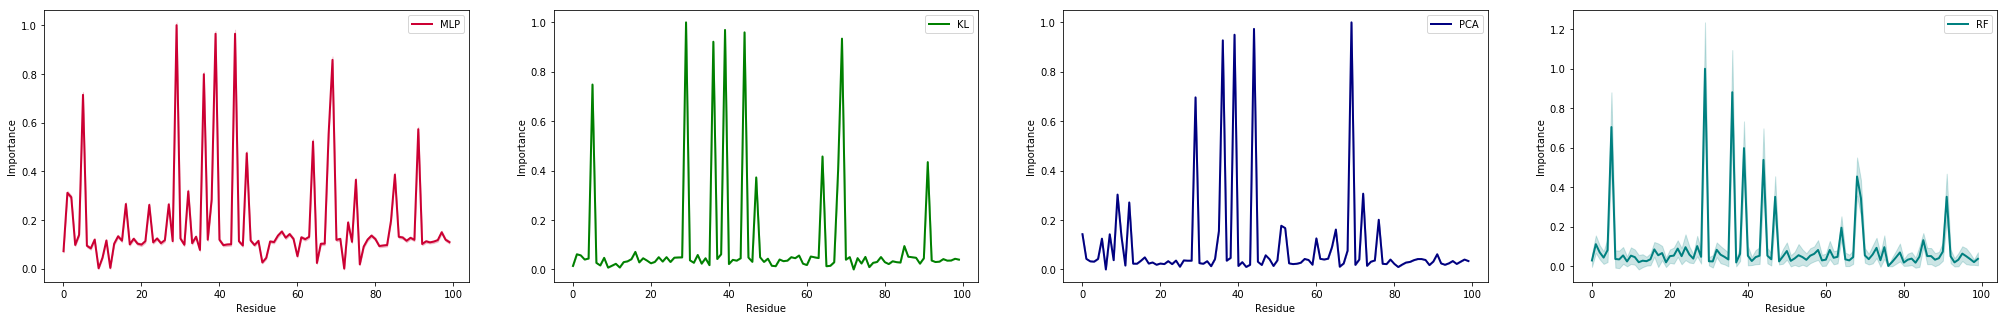

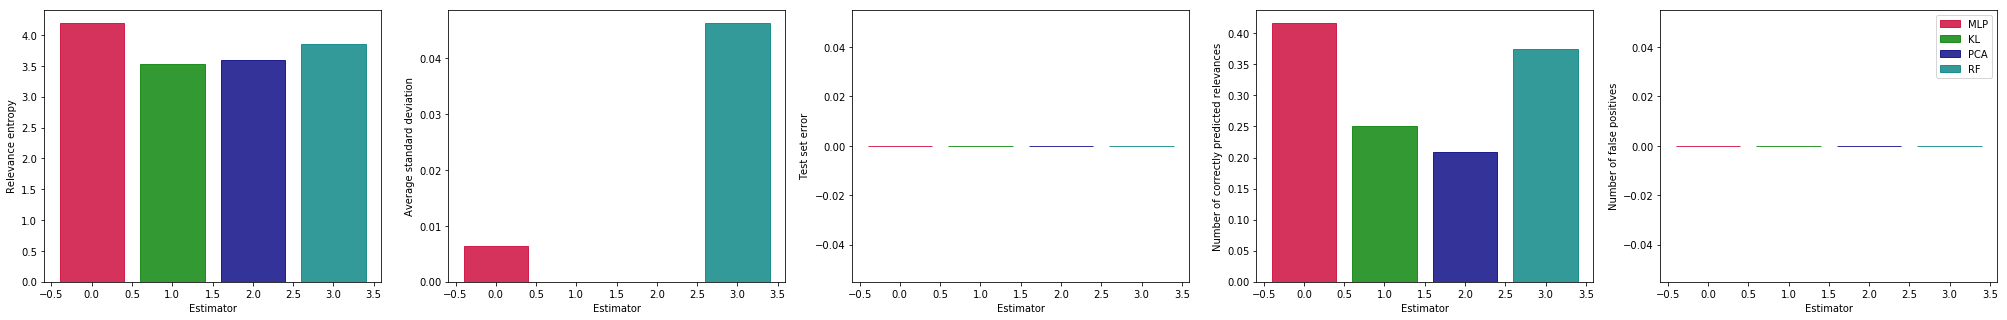

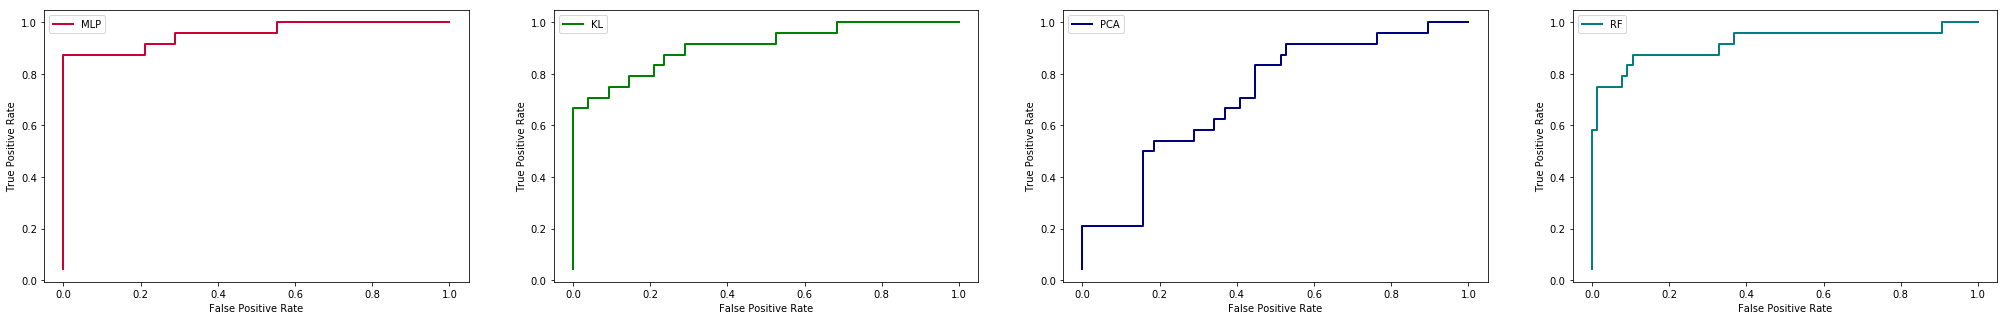

2018-11-23 17:40:48 dataGenNb-INFO: Done


In [10]:
visualization.visualize(postprocessors, show_performance=True)
logger.info("Done")

In [11]:
for p in postprocessors:
    out = np.vstack((p.fp_rate,p.tp_rate))
    np.savetxt('/media/mkasimova/Data2/NN_VSD/toy_model/testing.different.toy.models/ROC.'+p.extractor.name+fid+'dat',out.T)